## Naive and Seasonal Naive models
Code use for creation of naive models.
Those models predict for a window of 1,2,3 and 4 weeks ahead.
The first one use a rolling prediction using 1 week then move and predict. 
For the 2 weeks prediction use the last week value then moves and use the predict value to do the same and so on for the 3 and 4 week.

In [3]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
# get functions from utils.py
from utils import train_data,eval_metrics,plot_train_test

In [4]:
ari = pd.read_csv("data_ari.csv",sep=",",dtype={'location':str,'year_week':str,
                                                'value':np.float32,'relative_humidity_2m':np.float64,
                                                'temperature_2m_max':np.float64,'temperature_2m_min':np.float64},
                                                parse_dates=['truth_date'])


In [5]:
ili = pd.read_csv("data_ili.csv",sep=",",dtype={'location':str,'year_week':str,
                                                'value':np.float32,'relative_humidity_2m':np.float64,
                                                'temperature_2m_max':np.float64,'temperature_2m_min':np.float64},
                                                parse_dates=['truth_date'])
ili = ili.drop(columns=['Unnamed: 0']).reset_index(drop=True)


In [6]:
mape_ari = pd.DataFrame(columns=['location','model','prediction_window','mae','rmse'])
mape_ili = pd.DataFrame(columns=['location','model','prediction_window','mae','rmse'])

In [7]:
def naive_models_1_4_week_ahead_naive(train,test,country,mape):
    test['prediction_1_weeks'] = np.nan
    test["prediction_2_weeks"] = np.nan
    test["prediction_3_weeks"] = np.nan
    test["prediction_4_weeks"] = np.nan

    test.loc[test.index[0], "prediction_1_weeks"] = train.iloc[-1]["value"]
    test.loc[test.index[0], "prediction_2_weeks"] = train.iloc[-1]["value"]
    test.loc[test.index[0], "prediction_3_weeks"] = train.iloc[-1]["value"]
    test.loc[test.index[0], "prediction_4_weeks"] = train.iloc[-1]["value"]

    for i in range(len(test)):
        test.iloc[i, test.columns.get_loc("prediction_1_weeks")] = test.iloc[i-1]["value"]
        test.iloc[i, test.columns.get_loc("prediction_2_weeks")] = test.iloc[i-1]["value"]
        test.iloc[i, test.columns.get_loc("prediction_3_weeks")] = test.iloc[i-1]["value"]
        test.iloc[i, test.columns.get_loc("prediction_4_weeks")] = test.iloc[i-1]["value"]
    
    mape_mae_1_week,mape_rsme_1_week = eval_metrics(test["value"], test["prediction_1_weeks"])
    test_w2 = test.copy()
    test_w2["value"] = test_w2["value"].shift(-1)
    test_w2 = test_w2.dropna()
    mape_mae_2_week,mape_rsme_2_week = eval_metrics(test_w2["value"], test["prediction_2_weeks"].iloc[:len(test_w2)])
    test_w3 = test.copy()
    test_w3["value"] = test_w3["value"].shift(-2)
    test_w3 = test_w3.dropna()
    mape_mae_3_week,mape_rsme_3_week = eval_metrics(test_w3["value"], test["prediction_3_weeks"].iloc[:len(test_w3)])
    test_w4 = test.copy()
    test_w4["value"] = test_w4["value"].shift(-3)
    test_w4 = test_w4.dropna()
    mape_mae_4_week,mape_rsme_4_week = eval_metrics(test_w4["value"], test["prediction_4_weeks"].iloc[:len(test_w4)])
    mape = pd.concat([
        mape,
        pd.DataFrame([[country, 'naive','1_week',mape_mae_1_week,mape_rsme_1_week]], columns=['location', 'model','prediction_window', 'mae', 'rmse']),
        pd.DataFrame([[country, 'naive','2_week',mape_mae_2_week,mape_rsme_2_week]], columns=['location', 'model','prediction_window', 'mae', 'rmse']),
       pd.DataFrame([[country, 'naive','3_week',mape_mae_3_week,mape_rsme_3_week]], columns=['location', 'model','prediction_window', 'mae', 'rmse']),
        pd.DataFrame([[country, 'naive','4_week',mape_mae_4_week,mape_rsme_4_week]], columns=['location', 'model','prediction_window', 'mae', 'rmse'])],
          ignore_index=True)   
    return test,mape

In [8]:
def seasonal_naive_models_rolling(train, test, country, mape, horizon=4, seasonality=52):
    """
    Seasonal naive forecast: rolling week-by-week prediction.
    Metrics calculated by shifting value and slicing predictions like in user's method.
    """
    full = pd.concat([train, test]).copy()
    full = full.asfreq('W')

    test = test.copy()

    test['prediction_1_weeks'] = np.nan
    test["prediction_2_weeks"] = np.nan
    test["prediction_3_weeks"] = np.nan
    test["prediction_4_weeks"] = np.nan

    # Rolling predictions
    for i in range(len(test)):
        current_date = test.index[i]
        for h in range(1, horizon + 1):
            future_index = i + (h - 1)
            if future_index < len(test):
                target_date = test.index[future_index]
                lagged_date = target_date - pd.Timedelta(weeks=seasonality)
                if lagged_date in full.index:
                    test.loc[test.index[future_index], f"prediction_{h}_weeks"] = full.loc[lagged_date, "value"]

    # Evaluate metrics following your shifting style

    # h = 1
    mape_mae_1_week, mape_rsme_1_week = eval_metrics(test["value"], test["prediction_1_weeks"])

    # 2-4 weeks
    test_w2 = test.copy()
    test_w2["value"] = test_w2["value"].shift(-1)
    test_w2 = test_w2.dropna()
    mape_mae_2_week, mape_rsme_2_week = eval_metrics(
        test_w2["value"],
        test["prediction_2_weeks"].iloc[:len(test_w2)]
    )

    test_w3 = test.copy()
    test_w3["value"] = test_w3["value"].shift(-2)
    test_w3 = test_w3.dropna()
    mape_mae_3_week, mape_rsme_3_week = eval_metrics(
        test_w3["value"],
        test["prediction_3_weeks"].iloc[:len(test_w3)]
    )

    test_w4 = test.copy()
    test_w4["value"] = test_w4["value"].shift(-3)
    test_w4 = test_w4.dropna()
    mape_mae_4_week, mape_rsme_4_week = eval_metrics(
        test_w4["value"],
        test["prediction_4_weeks"].iloc[:len(test_w4)]
    )

    mape = pd.concat([
        mape,
        pd.DataFrame([[country, 'seasonal_naive', '1_week', mape_mae_1_week, mape_rsme_1_week]], columns=['location', 'model', 'prediction_window', 'mae', 'rmse']),
        pd.DataFrame([[country, 'seasonal_naive', '2_week', mape_mae_2_week, mape_rsme_2_week]], columns=['location', 'model', 'prediction_window', 'mae', 'rmse']),
        pd.DataFrame([[country, 'seasonal_naive', '3_week', mape_mae_3_week, mape_rsme_3_week]], columns=['location', 'model', 'prediction_window', 'mae', 'rmse']),
        pd.DataFrame([[country, 'seasonal_naive', '4_week', mape_mae_4_week, mape_rsme_4_week]], columns=['location', 'model', 'prediction_window', 'mae', 'rmse'])
    ], ignore_index=True)

    return test, mape


In [ ]:
name_ari = ari["location"].unique()
name_ili = ili["location"].unique()

C:\Users\flore\AppData\Local\Temp\ipykernel_17484\1855584307.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mape = pd.concat([


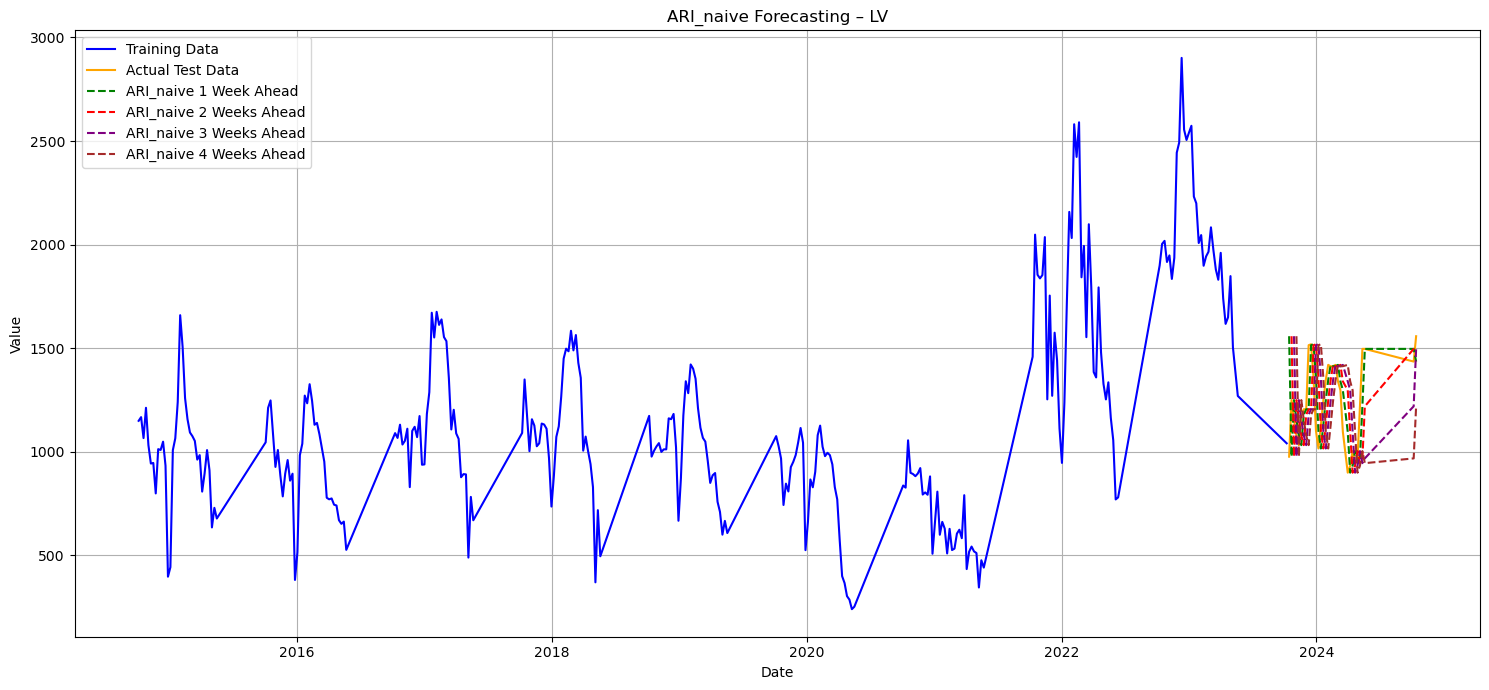

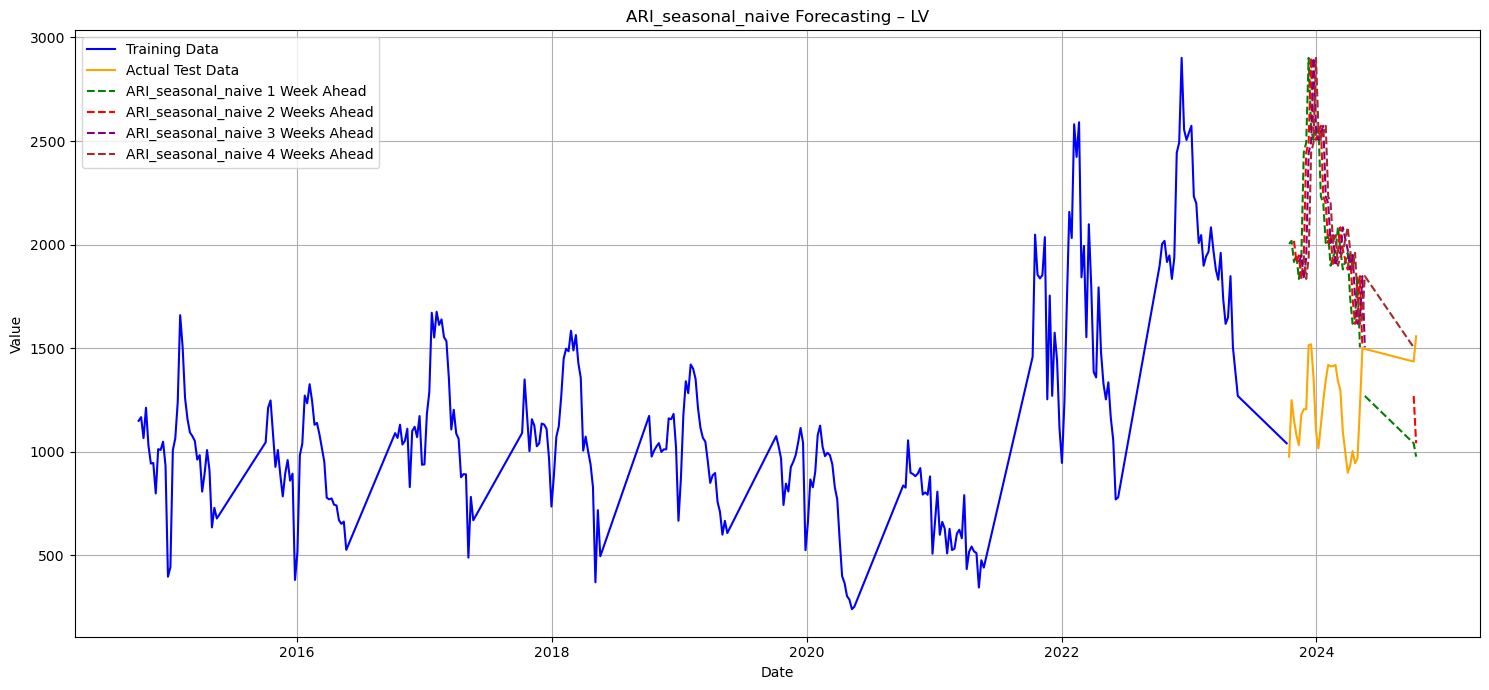

In [9]:
for i in ['LV']:
    train_ari,test_ari = train_data(ari,i,'2023-10-13')
    seasonal_test_ari,mape_ari = seasonal_naive_models_rolling(train_ari, test_ari, i, mape_ari)
    forecast_df,mape_ari = naive_models_1_4_week_ahead_naive(train_ari,test_ari,i,mape_ari)

    plot_train_test(train_ari,forecast_df,'ARI_naive',i,'naive')
    plot_train_test(train_ari,seasonal_test_ari,'ARI_seasonal_naive',i,'naive')
    

In [10]:
mape_ari

,location,model,prediction_window,mae,rmse
0,LV,seasonal_naive,1_week,835.633333,895.168123
1,LV,seasonal_naive,2_week,852.995061,942.210583
2,LV,seasonal_naive,3_week,859.528665,952.475660
3,LV,seasonal_naive,4_week,902.831163,973.572660
4,LV,naive,1_week,118.104033,169.225765
5,LV,naive,2_week,178.140614,221.712082
6,LV,naive,3_week,227.782250,276.404373
7,LV,naive,4_week,270.864437,317.347670


In [ ]:
for i in name_ili:
    train_ili,test_ili = train_data(ili,i,'2023-10-13')
    seasonal_test_ili,mape_ili = seasonal_naive_models_rolling(train_ili, test_ili, i, mape_ili)
    forecast_df_ili,mape_ili = naive_models_1_4_week_ahead_naive(train_ari,test_ari,i,mape_ili)
    plot_train_test(train_ili,forecast_df_ili,"ILI_naive",i,'naive')
    plot_train_test(train_ili,seasonal_test_ili,'ILI_seasonal_naive_model',i,'naive')
    

In [ ]:
mape_ari.to_csv("mape_ari.csv",index=False)
mape_ili.to_csv("mape_ili.csv",index=False)